In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
#from renormalization import (
#determine_r_max, rg_step, renormalized_field, dH_dH, G_r_prime, G_prime, phi_from_G)
from utils import required_initial_max_distance, logsumexp

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from numba import njit


# ----------------------------
# Deterministic RNG (Numba): xorshift64*
# ----------------------------

@njit(cache=True)
def _xorshift64star_next(state):
    # state: uint64
    x = state
    x ^= (x >> np.uint64(12))
    x ^= (x << np.uint64(25))
    x ^= (x >> np.uint64(27))
    state = x
    # Multiply by constant (xorshift64*)
    out = x * np.uint64(2685821657736338717)
    return state, out

@njit(cache=True)
def _u01_from_uint64(u):
    # Map uint64 -> float64 in [0,1)
    # Use top 53 bits for IEEE double mantissa
    return ((u >> np.uint64(11)) & np.uint64((1 << 53) - 1)) * (1.0 / float(1 << 53))


@njit(cache=True)
def generate_signs(D, p, seed):
    """
    Generate bond signs with an EXACT fraction p of -1 bonds.
    Total number of distances = D.
    Exactly floor(p*D) entries are -1, the rest +1, randomly permuted.
    """
    signs = np.empty(D + 1, dtype=np.int8)
    signs[0] = 0  # unused

    # number of negative bonds
    n_minus = int(p * D)
    n_plus  = D - n_minus

    # fill deterministically
    idx = 1
    for _ in range(n_minus):
        signs[idx] = -1
        idx += 1
    for _ in range(n_plus):
        signs[idx] = 1
        idx += 1

    # --- Fisher–Yates shuffle (Numba-safe) ---
    state = np.uint64(seed) ^ np.uint64(0x9E3779B97F4A7C15)
    if state == np.uint64(0):
        state = np.uint64(0xD1B54A32D192ED03)

    for i in range(D, 1, -1):
        state, rnd = _xorshift64star_next(state)
        j = 1 + (rnd % np.uint64(i))  # j in [1, i]
        tmp = signs[i]
        signs[i] = signs[j]
        signs[j] = tmp

    return signs


# ----------------------------
# Build signed long-range couplings J_r = sign[r] * J0 / r^a
# ----------------------------

@njit(cache=True)
def build_J_random(J0, a, D, p, seed):
    """
    Returns J[0..D], with random signs controlled by p.
    """
    signs = generate_signs(D, p, seed)
    J = np.zeros(D + 1, dtype=np.float64)
    for r in range(1, D + 1):
        J[r] = (J0 * signs[r]) / (r ** a)
    return J

# ----------------------------
# Staggered cell geometry
# ----------------------------

@njit(cache=True)
def right_pos_staggered(r):
    """
    Staggered right-cell positions:
      left cell fixed at [1,3,5]
      right cell alternates:
        r odd : m = 2 + 6k
        r even: m = 7 + 6k
      returns [m, m+2, m+4]
    """
    if r % 2 == 1:          # r = 1,3,5,... (even-type cell)
        k = (r - 1) // 2
        m = 2 + 6 * k
    else:                   # r = 2,4,6,... (odd-type cell)
        k = (r - 2) // 2
        m = 7 + 6 * k
    return np.array([m, m + 2, m + 4], dtype=np.int64)

@njit(cache=True)
def r_max(D):
    """
    Maximum r such that max intercell distance needed by staggered geometry fits in cutoff D.
    Uses dmax = max(right_pos) - min(left_pos) = (m+4) - 1 = m+3.
    """
    r = 1
    while True:
        rp = right_pos_staggered(r)
        dmax = rp[2] - 1
        if dmax > D:
            return r - 1
        r += 1

# ----------------------------
# Majority-rule configs for 3-spin cells (Numba-friendly arrays)
# ----------------------------

_all_spins = np.array(list(product([-1, 1], repeat=3)), dtype=np.int8)
plus_configs  = _all_spins[np.sum(_all_spins, axis=1) >=  1]
minus_configs = _all_spins[np.sum(_all_spins, axis=1) <= -1]

# ----------------------------
# Intracell energies for staggered cell: distances {2,2,4}
# ----------------------------

@njit(cache=True)
def intracell_energies(spins, J):
    J2 = J[2] if len(J) > 2 else 0.0
    J4 = J[4] if len(J) > 4 else 0.0

    n = spins.shape[0]
    E = np.empty(n, dtype=np.float64)
    for i in range(n):
        s0 = spins[i, 0]
        s1 = spins[i, 1]
        s2 = spins[i, 2]
        E[i] = (J2 * (s0 * s1 + s1 * s2) + J4 * (s0 * s2))
    return E

# ----------------------------
# Compute log R(++) and log R(+-) at staggered separation r
# ----------------------------

@njit(cache=True)
def log_Rpp_Rpm(r, J):
    D = len(J) - 1

    # Intracell energies
    E_plus  = intracell_energies(plus_configs,  J)
    E_minus = intracell_energies(minus_configs, J)

    # Physical lattice positions
    left_pos  = np.array([1, 3, 5], dtype=np.int64)
    right_pos = right_pos_staggered(r)

    # Distance matrix (3x3)
    distances = np.empty((3, 3), dtype=np.int64)
    for a in range(3):
        for b in range(3):
            distances[a, b] = abs(right_pos[b] - left_pos[a])

    n_plus  = plus_configs.shape[0]
    n_minus = minus_configs.shape[0]

    # R(++)
    totals_pp = np.empty(n_plus * n_plus, dtype=np.float64)
    idx = 0
    for iL in range(n_plus):
        sL = plus_configs[iL]
        EL = E_plus[iL]
        for iR in range(n_plus):
            sR = plus_configs[iR]
            ER = E_plus[iR]
            E_int = 0.0
            for a in range(3):
                for b in range(3):
                    d = distances[a, b]
                    if d <= D:
                        E_int += J[d] * sL[a] * sR[b]
            totals_pp[idx] = EL + ER + E_int
            idx += 1

    # R(+-)
    totals_pm = np.empty(n_plus * n_minus, dtype=np.float64)
    idx = 0
    for iL in range(n_plus):
        sL = plus_configs[iL]
        EL = E_plus[iL]
        for iR in range(n_minus):
            sR = minus_configs[iR]
            ER = E_minus[iR]
            E_int = 0.0
            for a in range(3):
                for b in range(3):
                    d = distances[a, b]
                    if d <= D:
                        E_int += J[d] * sL[a] * sR[b]
            totals_pm[idx] = EL + ER + E_int
            idx += 1

    log_pp = logsumexp(totals_pp)
    log_pm = logsumexp(totals_pm)
    return log_pp, log_pm

# ----------------------------
# One RG step (staggered, signed couplings)
# ----------------------------

@njit(cache=True)
def rg_step(J, a):
    """
    Computes a single RG step producing J' in the same fixed-length convention
    as your prior correct implementation. We only fill distances up to r_max(D'),
    where D' = (D - 2) // 3 is the max distance representable after decimation.

    NOTE: This assumes the same blocking/decimation logic you used previously:
          - r' indexes the staggered right-cell placement
          - mapping from physical cutoff D to new cutoff D' consistent with D_new = (D-2)//3
          - definition of J'_r from log R(++) and log R(+-): J'_r = 0.5 * (log_pp - log_pm)
          - keep 'a' for compatibility (even if not used inside the step)
    """
    D = len(J) - 1
    Dp = (D - 2) // 3
    if Dp < 1:
        return np.zeros(1, dtype=np.float64)

    Jp = np.zeros(Dp + 1, dtype=np.float64)

    rmax_p = r_max(D)  # max r supported by current cutoff for staggered geometry
    # But the new vector only stores up to Dp. We compute for r=1..min(Dp, rmax_p')
    # In practice, r_max should be recomputed against the *current* cutoff D for the needed intercell distances.
    rstop = Dp
    if rstop > rmax_p:
        rstop = rmax_p

    for r in range(1, rstop + 1):
        log_pp, log_pm = log_Rpp_Rpm(r, J)
        Jp[r] = 0.5 * (log_pp - log_pm)

    return Jp

# ----------------------------
# RG flow generator (random signs controlled by p)
# ----------------------------

def generate_rg_flow_random_signs(J0, a, D, n_steps, p, seed=12345):
    """
    Creates initial signed power-law couplings with AF fraction p,
    then iterates RG steps deterministically (no re-randomization each step).
    """
    J = build_J_random(J0, a, D, p, seed)
    flow = [J.copy()]
    for _ in range(n_steps):
        J = rg_step(J, a)
        flow.append(J.copy())
    return flow

def plot_rg_flow(flow, distances_to_plot=None):
    n_steps_plus_1 = len(flow)
    steps = np.arange(n_steps_plus_1)

    if distances_to_plot is None:
        distances_to_plot = [1, 2, 3, 4, 5]

    plt.figure(figsize=(7, 5))
    for r in distances_to_plot:
        # Some later RG steps shrink D, so skip if r out of range at a given step.
        vals = []
        valid_steps = []
        for k, J in enumerate(flow):
            if 1 <= r <= (len(J) - 1):
                vals.append(J[r])
                valid_steps.append(k)
        if len(vals) > 0:
            plt.plot(np.array(valid_steps), np.array(vals), marker='o', label=f"J_{r}")

    plt.xlabel("RG step")
    plt.ylabel("Coupling $J_r$")
    plt.title("Staggered RG flow (random initial signs)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def determine_phase_sink(
    J0, a, max_dist_final, n_steps_total,
    p=0.0, seed=19,
    track_r=(2,),
    eval_step=None,
    thr_dis=1e-2,
    thr_ord=1e2,
):
    """
    Determine the RG phase sink from the signed-coupling staggered RG flow.

    Decision rule (evaluated at a chosen RG step):
      - Disorder:  |J_r| < thr_dis  for all r in track_r
      - Ferro:     |J_r| > thr_ord  for all r in track_r AND J_r > 0 for all
      - Antiferro: |J_r| > thr_ord  for all r in track_r AND J_r < 0 for all

    Parameters
    ----------
    max_dist_final : int
        Desired final cutoff after n_steps_total (used to compute required initial D0).
    n_steps_total : int
        Total RG steps to generate.
    eval_step : int or None
        Step at which to evaluate sink. If None, uses the last step (n_steps_total).

    Returns
    -------
    phase : str
        "disorder", "ferro", "antiferro", or "undetermined".
    info : dict
        Diagnostic details (step used, tracked couplings, etc.).
    """
    # initial cutoff large enough so that after n_steps_total we still have max_dist_final
    D0 = required_initial_max_distance(max_dist_final, n_steps_total)

    # generate signed initial condition and RG flow
    flow = generate_rg_flow_random_signs(J0=J0, a=a, D=D0, n_steps=n_steps_total, p=p, seed=seed)

    if eval_step is None:
        eval_step = n_steps_total
    if eval_step < 0:
        eval_step = 0
    if eval_step > n_steps_total:
        eval_step = n_steps_total

    J_eval = flow[eval_step]
    D_eval = len(J_eval) - 1

    # collect tracked couplings (must exist at eval step)
    tracked = {}
    missing = []
    for r in track_r:
        if 1 <= r <= D_eval:
            tracked[int(r)] = float(J_eval[r])
        else:
            missing.append(int(r))

    # if any requested distance is not available at the evaluation step, declare undetermined
    if len(missing) > 0:
        return "undetermined", {
            "reason": "missing_tracked_distances_at_eval_step",
            "eval_step": int(eval_step),
            "D_eval": int(D_eval),
            "missing_r": missing,
            "tracked": tracked,
        }

    vals = np.array([tracked[int(r)] for r in track_r], dtype=np.float64)
    abs_vals = np.abs(vals)

    # Disorder
    if np.all(abs_vals < thr_dis):
        return "disorder", {
            "eval_step": int(eval_step),
            "tracked": tracked,
            "criterion": f"all |J_r| < {thr_dis}",
        }

    # Ferro / Antiferro
    if np.all(abs_vals > thr_ord):
        if np.all(vals > 0.0):
            return "ferro", {
                "eval_step": int(eval_step),
                "tracked": tracked,
                "criterion": f"all |J_r| > {thr_ord} and all J_r > 0",
            }
        if np.all(vals < 0.0):
            return "antiferro", {
                "eval_step": int(eval_step),
                "tracked": tracked,
                "criterion": f"all |J_r| > {thr_ord} and all J_r < 0",
            }

    return "undetermined", {
        "eval_step": int(eval_step),
        "tracked": tracked,
        "criterion": "did not meet disorder/ferro/antiferro thresholds coherently",
        "thr_dis": float(thr_dis),
        "thr_ord": float(thr_ord),
    }


def scan_phase_sinks_p_T(
    p_values,
    T_values,
    a,
    max_dist_final,
    n_steps_total,
    track_r=(2, 3, 4, 5),
    eval_step=None,
    seed=12345,
    thr_dis=1e-2,
    thr_ord=1e2,
):
    """
    Scan (p, T) grid, classify phase sink at each point, and return 4 arrays of points:
      - disorder_points:     shape (Nd, 2) columns [p, T]
      - ferro_points:        shape (Nf, 2) columns [p, T]
      - antiferro_points:    shape (Na, 2) columns [p, T]
      - undetermined_points: shape (Nu, 2) columns [p, T]
    """
    p_values = np.asarray(p_values, dtype=np.float64)
    T_values = np.asarray(T_values, dtype=np.float64)

    disorder_pts = []
    ferro_pts = []
    antiferro_pts = []
    undet_pts = []

    for p in p_values:
        for T in T_values:
            J0 = 1.0 / float(T)

            phase, _info = determine_phase_sink(
                J0=J0,
                a=a,
                max_dist_final=max_dist_final,
                n_steps_total=n_steps_total,
                p=float(p),
                seed=int(seed),
                track_r=track_r,
                eval_step=eval_step,
                thr_dis=thr_dis,
                thr_ord=thr_ord,
            )

            if phase == "disorder":
                disorder_pts.append((p, T))
            elif phase == "ferro":
                ferro_pts.append((p, T))
            elif phase == "antiferro":
                antiferro_pts.append((p, T))
            else:
                undet_pts.append((p, T))

    disorder_points = np.array(disorder_pts, dtype=np.float64).reshape((-1, 2))
    ferro_points = np.array(ferro_pts, dtype=np.float64).reshape((-1, 2))
    antiferro_points = np.array(antiferro_pts, dtype=np.float64).reshape((-1, 2))
    undetermined_points = np.array(undet_pts, dtype=np.float64).reshape((-1, 2))

    return disorder_points, ferro_points, antiferro_points, undetermined_points


def plot_phase_points_p_T(
    disorder_points,
    ferro_points,
    antiferro_points,
    undetermined_points,
    title="Phase sinks in (p, T) plane",
    marker_size=12,
):
    """
    Scatter plot of phase points in p vs T=1/J plane.
    Uses square markers ('s') with fixed colors per phase.
    """
    plt.figure(figsize=(7.5, 5.5))

    if disorder_points.size:
        plt.scatter(disorder_points[:, 0], disorder_points[:, 1],
                    s=marker_size, marker='s', c='tab:gray', label='Disorder')
    if ferro_points.size:
        plt.scatter(ferro_points[:, 0], ferro_points[:, 1],
                    s=marker_size, marker='s', c='tab:red', label='Ferro')
    if antiferro_points.size:
        plt.scatter(antiferro_points[:, 0], antiferro_points[:, 1],
                    s=marker_size, marker='s', c='tab:blue', label='Antiferro')
    if undetermined_points.size:
        plt.scatter(undetermined_points[:, 0], undetermined_points[:, 1],
                    s=marker_size, marker='s', c='tab:orange', label='Undetermined')

    plt.xlabel("p (fraction of negative bonds)")
    plt.ylabel("Temperature T = 1/J0")
    plt.title(title)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

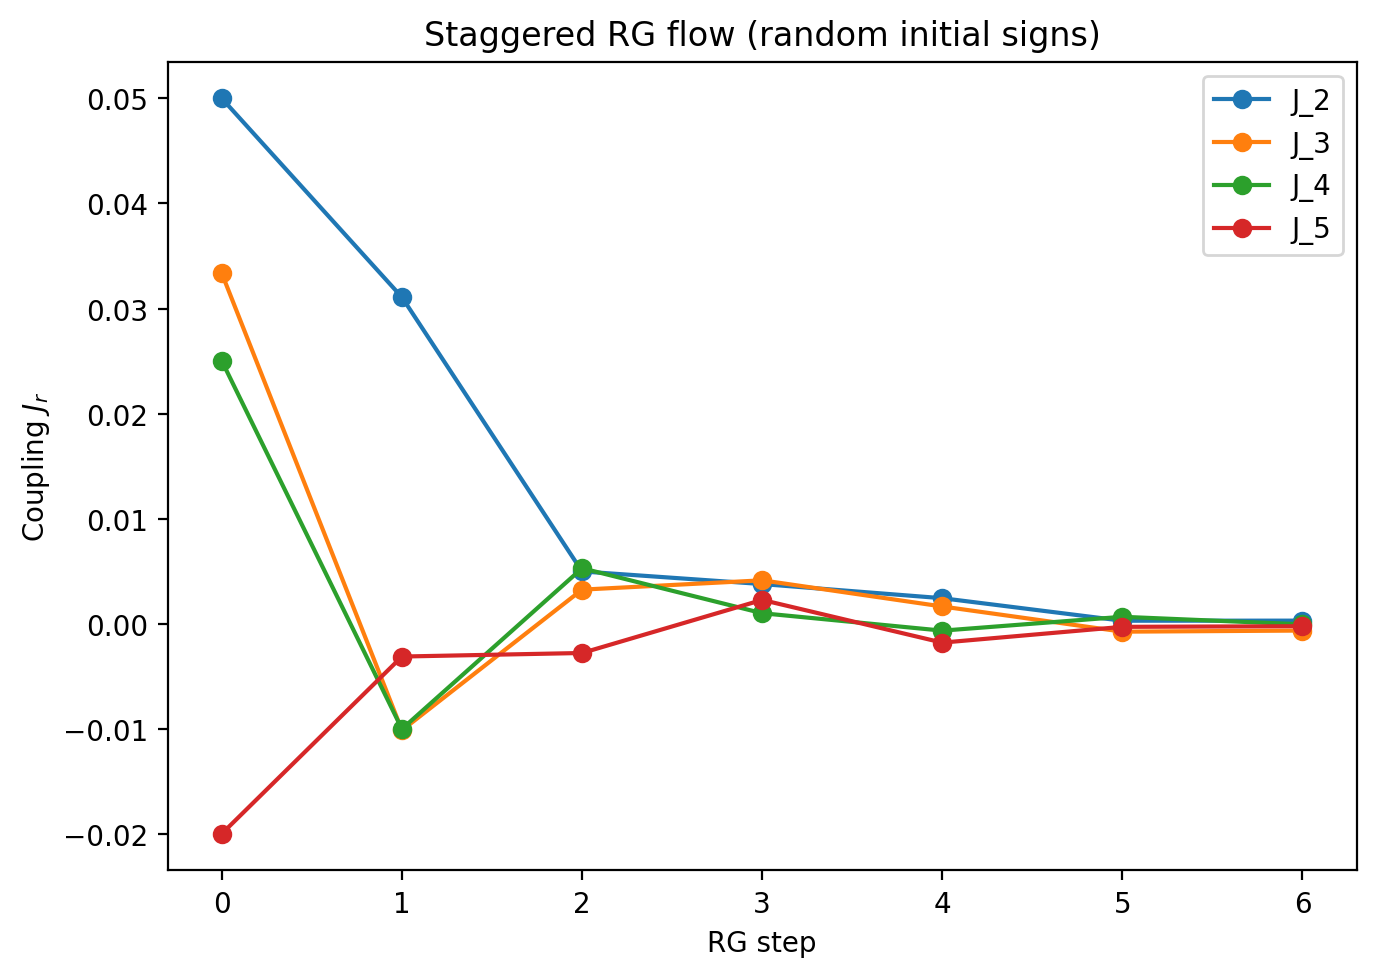

In [140]:
D0 = required_initial_max_distance(max_dist_final=30, n_steps=10)
flow = generate_rg_flow_random_signs(J0=.1, a=1., D=D0, n_steps=6, p=.5, seed=2)
plot_rg_flow(flow, distances_to_plot=[2,3,4,5])

In [147]:
determine_phase_sink(
    J0=1, a=1.5, max_dist_final=30, n_steps_total=10,
    p=0.0, track_r=(2,))

('disorder',
 {'eval_step': 10,
  'tracked': {2: 0.0031572406245206075, 3: 0.0031536779817078475},
  'criterion': 'all |J_r| < 0.01'})

In [ ]:
p_vals = np.linspace(0.0, 1, 23)
T_vals = np.linspace(0.1, 5, 23)

dis, fer, anti, und = scan_phase_sinks_p_T(
    p_values=p_vals,
    T_values=T_vals,
    a=1.5,
    max_dist_final=30,
    n_steps_total=10,
    track_r=(2,),
    eval_step=None,
    seed=19,
)
plot_phase_points_p_T(dis, fer, anti, und, title="Phase diagram (sink classification)")